## Estate Workers Productivity Data Challenge-2022

In [1]:
# # After running these, restart runtime.
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
! pip install -U --force-reinstall matplotlib

### PART A: Importing Libraries and data

In [2]:
#Importing Libraries
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgbm
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, QuantileTransformer
%matplotlib inline
pd.set_option('display.max_columns', None)

In [3]:
#Fetching Data
Employee_data = pd.read_csv("Employee.csv")
Fields_data = pd.read_csv("Fields.csv")
WorkCode_data = pd.read_csv("WorkCode.csv")
WorkDetails_data = pd.read_csv("WorkDetails.csv")

In [4]:
#Making copies of the fetched data, manipulations will be done on them
Employee = Employee_data.copy()
Fields = Fields_data.copy()
WorkCode = WorkCode_data.copy()
WorkDetails = WorkDetails_data.copy()

### PART B: Cleaning the datasets

* #### Cleaning Employee Data 

In [5]:
#Checking Employee Data
Employee.head()

Estate Division  EmpCode Gender                   DateofJoin PAMACT
0    EST       HO      101      M  1960-01-01 00:00:00.0000000      T
1    EST       HO      404      M  1965-04-01 00:00:00.0000000      A
2    EST       HO     1616      F  1970-10-16 00:00:00.0000000      A
3    EST       HO     2727      F  1972-01-01 00:00:00.0000000      A
4    EST       HO     3030      M  1968-12-01 00:00:00.0000000      T

In [6]:
#Checking shape
Employee.shape

(2015, 6)

In [7]:
#Checking datatypes of column
Employee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2015 entries, 0 to 2014
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Estate      2015 non-null   object
 1   Division    2015 non-null   object
 2   EmpCode     2015 non-null   int64 
 3   Gender      2015 non-null   object
 4   DateofJoin  1847 non-null   object
 5   PAMACT      2009 non-null   object
dtypes: int64(1), object(5)
memory usage: 94.6+ KB


In [8]:
#Removing Null values
print(Employee.isna().sum())
Employee.dropna(inplace=True)
Employee.isna().sum()

Estate          0
Division        0
EmpCode         0
Gender          0
DateofJoin    168
PAMACT          6
dtype: int64


Estate        0
Division      0
EmpCode       0
Gender        0
DateofJoin    0
PAMACT        0
dtype: int64

In [9]:
#Checking Duplicated rows
print(Employee.duplicated().sum())

0


In [10]:
#Removing Estate column since it consist of only 1 value
print(Employee["Estate"].unique())
Employee.drop(axis=1, columns=["Estate"], inplace=True)
Employee.info()

['EST']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1847 entries, 0 to 2007
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Division    1847 non-null   object
 1   EmpCode     1847 non-null   int64 
 2   Gender      1847 non-null   object
 3   DateofJoin  1847 non-null   object
 4   PAMACT      1847 non-null   object
dtypes: int64(1), object(4)
memory usage: 86.6+ KB


* #### Cleaning Fields Data 

In [11]:
#Checking Fields Data
Fields.head()

EState Division CropType Field  Area  NumberOfTree Type
0    EST       MD        T    8A   1.5       19425.0    R
1    EST       MD        T    6A   0.8        9302.0    R
2    EST       MD        T     6  12.5       96063.0    R
3    EST       MD        T    10  16.0           NaN    R
4    EST       MD        T     7   7.0       25417.0    R

In [12]:
#Checking shape
Fields.shape

(63, 7)

In [13]:
#Checking datatypes of columns
Fields.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   EState        63 non-null     object 
 1   Division      63 non-null     object 
 2   CropType      63 non-null     object 
 3   Field         63 non-null     object 
 4   Area          63 non-null     float64
 5   NumberOfTree  61 non-null     float64
 6   Type          63 non-null     object 
dtypes: float64(2), object(5)
memory usage: 3.6+ KB


In [14]:
#Checking Null Values and removing them
print(Fields.isna().sum())
Fields.dropna(inplace=True)
Fields.isna().sum()

EState          0
Division        0
CropType        0
Field           0
Area            0
NumberOfTree    2
Type            0
dtype: int64


EState          0
Division        0
CropType        0
Field           0
Area            0
NumberOfTree    0
Type            0
dtype: int64

In [15]:
#Checking Duplicated rows
print(Fields.duplicated().sum())

0


In [16]:
#Removing Estate column since it consist of only 1 value
print(Fields["EState"].unique())
Fields.drop(axis=1, columns=["EState"], inplace=True)
Fields.info()

['EST']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 61 entries, 0 to 62
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Division      61 non-null     object 
 1   CropType      61 non-null     object 
 2   Field         61 non-null     object 
 3   Area          61 non-null     float64
 4   NumberOfTree  61 non-null     float64
 5   Type          61 non-null     object 
dtypes: float64(2), object(4)
memory usage: 3.3+ KB


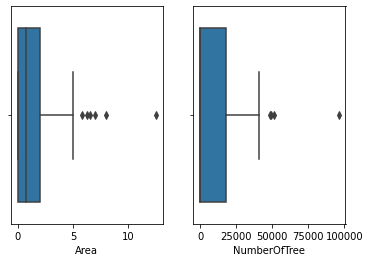

In [17]:
#Checking outliers
fig, ax =plt.subplots(1,2)
sns.boxplot(x = 'Area', data = Fields, ax = ax[0])
sns.boxplot(x = 'NumberOfTree', data = Fields, ax = ax[1])
fig.show()

ORIGINAL SHAPE: (61, 6)
SHAPE AFTER REMOVING EXTREME OUTLIERS: (54, 6)


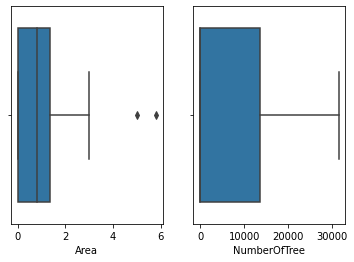

In [18]:
# Calculating 95% of Area and NumberOfTree, and making the dataset in between these values.
q_hi  = Fields["Area"].quantile(0.95)
print("ORIGINAL SHAPE: "+str(Fields.shape))
Fields = Fields[(Fields["Area"] < q_hi)]
#Doing same thing for PASSENGERS
q_hi = Fields["NumberOfTree"].quantile(0.95)
Fields = Fields[(Fields["NumberOfTree"] < q_hi)]
print("SHAPE AFTER REMOVING EXTREME OUTLIERS: "+str(Fields.shape))

# After removing outliers
fig, ax =plt.subplots(1,2)
sns.boxplot(x = 'Area', data = Fields, ax = ax[0])
sns.boxplot(x = 'NumberOfTree', data = Fields, ax = ax[1])
fig.show()

##### Note: I have removed some extreme outliers, where the difference was great between normal values and extreme values. You can see I have not completely removed outliers, because they are not corrupting the data and they are required for the analysis to be valid. 

* #### Cleaning WorkCode Data

In [19]:
#Checking WorkCode data
WorkCode.head()

WorCode Crop Type
0     CHC    T    R
1     TPR    T    R
2     MUS    T    R
3     WBN    T    R
4     EFD    T    R

In [20]:
#Checking Shape
WorkCode.shape

(483, 3)

In [21]:
#Checking Datatypes of columns
WorkCode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 483 entries, 0 to 482
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   WorCode  483 non-null    object
 1   Crop     483 non-null    object
 2   Type     479 non-null    object
dtypes: object(3)
memory usage: 11.4+ KB


In [22]:
#Since I have to merge WorkCode with WorkDetails, hence making a primary key as it doesnot exist
WorkCode["Work"] = WorkCode["WorCode"]
WorkCode.drop(axis=1, columns=["WorCode"], inplace=True)
WorkCode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 483 entries, 0 to 482
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Crop    483 non-null    object
 1   Type    479 non-null    object
 2   Work    483 non-null    object
dtypes: object(3)
memory usage: 11.4+ KB


In [23]:
#Checking Null Values and removing them
print(WorkCode.isna().sum())
WorkCode.dropna(inplace=True)
WorkCode.isna().sum()

Crop    0
Type    4
Work    0
dtype: int64


Crop    0
Type    0
Work    0
dtype: int64

In [24]:
#Checking Duplicated rows and removing them
print(WorkCode.duplicated().sum())
WorkCode.drop_duplicates(inplace=True)
print(WorkCode.duplicated().sum())

2
0


* #### Cleaning WorkDetails Data

In [25]:
#Checking WorkDetails data
WorkDetails.head()

Year  Month  Day Estate Division  EmpCode Work  NumberofDays  Qty  \
0  2014     10   17    EST       UD   574993  LLO           1.0  0.0   
1  2014     10   17    EST       UD   576104  LLO           1.0  0.0   
2  2014     10   17    EST       UD   579437  LLO           1.0  0.0   
3  2014     10   17    EST       UD   579538  LLO           1.0  0.0   
4  2014     10   17    EST       UD   541865  LLO           1.0  0.0   

   ExtraKilos  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0

In [26]:
#Checking shape
WorkDetails.shape

(1110902, 10)

In [27]:
#Checking datatypes of columns
WorkDetails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1110902 entries, 0 to 1110901
Data columns (total 10 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Year          1110902 non-null  int64  
 1   Month         1110902 non-null  int64  
 2   Day           1110902 non-null  int64  
 3   Estate        1110902 non-null  object 
 4   Division      1110902 non-null  object 
 5   EmpCode       1110902 non-null  int64  
 6   Work          1110902 non-null  object 
 7   NumberofDays  1110902 non-null  float64
 8   Qty           662706 non-null   float64
 9   ExtraKilos    662706 non-null   float64
dtypes: float64(3), int64(4), object(3)
memory usage: 84.8+ MB


In [28]:
#Checking Null Values and removing them
print(WorkDetails.isna().sum())
WorkDetails.dropna(inplace=True)
WorkDetails.isna().sum()

Year                 0
Month                0
Day                  0
Estate               0
Division             0
EmpCode              0
Work                 0
NumberofDays         0
Qty             448196
ExtraKilos      448196
dtype: int64


Year            0
Month           0
Day             0
Estate          0
Division        0
EmpCode         0
Work            0
NumberofDays    0
Qty             0
ExtraKilos      0
dtype: int64

In [29]:
#Checking Duplicated rows and removing them
print(WorkDetails.duplicated().sum())
WorkDetails.drop_duplicates(inplace=True)
print(WorkDetails.duplicated().sum())

36
0


In [30]:
#Removing Estate column since it consist of only 1 value
print(WorkDetails["Estate"].unique())
WorkDetails.drop(axis=1, columns=["Estate"], inplace=True)
WorkDetails.info()

['EST']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 662670 entries, 0 to 1110901
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Year          662670 non-null  int64  
 1   Month         662670 non-null  int64  
 2   Day           662670 non-null  int64  
 3   Division      662670 non-null  object 
 4   EmpCode       662670 non-null  int64  
 5   Work          662670 non-null  object 
 6   NumberofDays  662670 non-null  float64
 7   Qty           662670 non-null  float64
 8   ExtraKilos    662670 non-null  float64
dtypes: float64(3), int64(4), object(2)
memory usage: 50.6+ MB


In [31]:
#Converting Year, Month and Day to a single Date column
WorkDetails["Date"] = pd.to_datetime((WorkDetails["Year"].astype(str)+"-"+WorkDetails["Month"].astype(str)+"-"+WorkDetails["Day"].astype(str)), infer_datetime_format=True)
#Dropping Year Month and Day columns
WorkDetails.drop(axis=1, columns=["Month","Day"], inplace=True)
WorkDetails.head()

Year Division  EmpCode Work  NumberofDays  Qty  ExtraKilos       Date
0  2014       UD   574993  LLO           1.0  0.0         0.0 2014-10-17
1  2014       UD   576104  LLO           1.0  0.0         0.0 2014-10-17
2  2014       UD   579437  LLO           1.0  0.0         0.0 2014-10-17
3  2014       UD   579538  LLO           1.0  0.0         0.0 2014-10-17
4  2014       UD   541865  LLO           1.0  0.0         0.0 2014-10-17

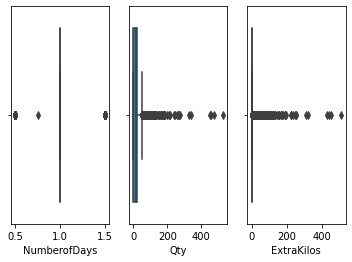

In [32]:
#Checking outliers
fig, ax =plt.subplots(1,3)
sns.boxplot(x = 'NumberofDays', data = WorkDetails, ax = ax[0])
sns.boxplot(x = 'Qty', data = WorkDetails, ax = ax[1])
sns.boxplot(x = 'ExtraKilos', data = WorkDetails, ax = ax[2])
fig.show()

ORIGINAL SHAPE: (662670, 8)
SHAPE AFTER REMOVING EXTREME OUTLIERS: (614347, 8)


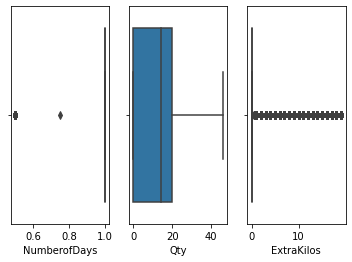

In [33]:
# Calculating 99% of Area and NumberOfTree, and making the dataset in between these values.
q_hi  = WorkDetails["NumberofDays"].quantile(0.99)
print("ORIGINAL SHAPE: "+str(WorkDetails.shape))
WorkDetails = WorkDetails[(WorkDetails["NumberofDays"] < q_hi)]
#Doing same thing for PASSENGERS
q_hi = WorkDetails["Qty"].quantile(0.99)
WorkDetails = WorkDetails[(WorkDetails["Qty"] < q_hi)]
#Doing same thing for PASSENGERS
q_hi = WorkDetails["ExtraKilos"].quantile(0.99)
WorkDetails = WorkDetails[(WorkDetails["ExtraKilos"] < q_hi)]
print("SHAPE AFTER REMOVING EXTREME OUTLIERS: "+str(WorkDetails.shape))

# After removing outliers
fig, ax =plt.subplots(1,3)
sns.boxplot(x = 'NumberofDays', data = WorkDetails, ax = ax[0])
sns.boxplot(x = 'Qty', data = WorkDetails, ax = ax[1])
sns.boxplot(x = 'ExtraKilos', data = WorkDetails, ax = ax[2])
fig.show()

##### Note: I have removed some extreme outliers, where the difference was great between normal values and extreme values. You can see I have not completely removed outliers, because they are not corrupting the data and they are required for the analysis to be valid. 

### PART B: Merging the datasets

In [34]:
#Checking Employee Data
Employee.head()

Division  EmpCode Gender                   DateofJoin PAMACT
0       HO      101      M  1960-01-01 00:00:00.0000000      T
1       HO      404      M  1965-04-01 00:00:00.0000000      A
2       HO     1616      F  1970-10-16 00:00:00.0000000      A
3       HO     2727      F  1972-01-01 00:00:00.0000000      A
4       HO     3030      M  1968-12-01 00:00:00.0000000      T

In [35]:
#Checking Field Data
Fields.head()

Division CropType Field  Area  NumberOfTree Type
0       MD        T    8A   1.5       19425.0    R
1       MD        T    6A   0.8        9302.0    R
6       MD        T    7A   0.8        9653.0    R
8       MD        T     5   5.0       31505.0    R
9       MD        T    19   5.8       30015.0    R

In [36]:
#Checking WorkCode data
WorkCode.head()

Crop Type Work
0    T    R  CHC
1    T    R  TPR
2    T    R  MUS
3    T    R  WBN
4    T    R  EFD

In [37]:
#Checking WorkDetails data
WorkDetails.head()

Year Division  EmpCode Work  NumberofDays  Qty  ExtraKilos       Date
0  2014       UD   574993  LLO           1.0  0.0         0.0 2014-10-17
1  2014       UD   576104  LLO           1.0  0.0         0.0 2014-10-17
2  2014       UD   579437  LLO           1.0  0.0         0.0 2014-10-17
3  2014       UD   579538  LLO           1.0  0.0         0.0 2014-10-17
4  2014       UD   541865  LLO           1.0  0.0         0.0 2014-10-17

In [38]:
# Merging WorkCode and WorkDetails
working_detail = pd.merge(WorkCode, WorkDetails, how='outer')
# Merging Employee and Fields
Employee_field = pd.merge(Employee, Fields, how='outer')
# Merging working_detail and Employee_field
Final_dataset = pd.merge(working_detail, Employee_field, how='outer')
df = Final_dataset.copy()

In [39]:
df.dropna(inplace=True)
df.head()

Crop Type Work    Year Division   EmpCode  NumberofDays  Qty  \
18414    T    R  WBN  2012.0       MD  390466.0           1.0  0.0   
18415    T    R  WBN  2012.0       MD  390466.0           1.0  0.0   
18416    T    R  WBN  2012.0       MD  390466.0           1.0  0.0   
18417    T    R  WBN  2012.0       MD  390466.0           1.0  0.0   
18418    T    R  WBN  2012.0       MD  390466.0           1.0  0.0   

       ExtraKilos       Date Gender                   DateofJoin PAMACT  \
18414         0.0 2012-03-01      M  1977-05-18 00:00:00.0000000      A   
18415         0.0 2012-03-01      M  1977-05-18 00:00:00.0000000      A   
18416         0.0 2012-03-01      M  1977-05-18 00:00:00.0000000      A   
18417         0.0 2012-03-01      M  1977-05-18 00:00:00.0000000      A   
18418         0.0 2012-03-01      M  1977-05-18 00:00:00.0000000      A   

      CropType Field  Area  NumberOfTree  
18414        T    8A   1.5       19425.0  
18415        T    6A   0.8        9302.0  
18416        T    7A   0.8        9653.0  
18417        T     5   5.0       31505.0  
18418        T    19   5.8       30015.0

### PART C: Finding Insights/Observations

In [40]:
# Since both columns are same, removing one of them
(df["Crop"]==df["CropType"]).value_counts()
df.drop(axis=1, columns=["Crop"], inplace=True)

In [41]:
#Checking datatypes of merged columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1715588 entries, 18414 to 2178980
Data columns (total 16 columns):
 #   Column        Dtype         
---  ------        -----         
 0   Type          object        
 1   Work          object        
 2   Year          float64       
 3   Division      object        
 4   EmpCode       float64       
 5   NumberofDays  float64       
 6   Qty           float64       
 7   ExtraKilos    float64       
 8   Date          datetime64[ns]
 9   Gender        object        
 10  DateofJoin    object        
 11  PAMACT        object        
 12  CropType      object        
 13  Field         object        
 14  Area          float64       
 15  NumberOfTree  float64       
dtypes: datetime64[ns](1), float64(7), object(8)
memory usage: 222.5+ MB


<AxesSubplot:xlabel='Area', ylabel='Number of Crops'>

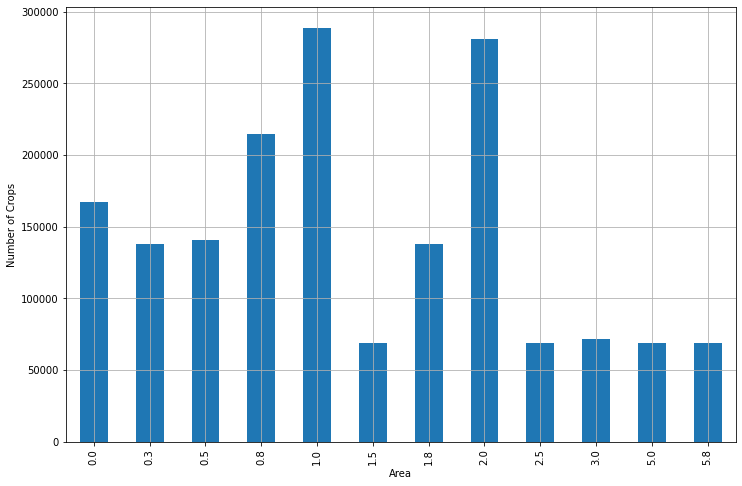

In [42]:
#Number of crops in each area
df.groupby("Area")["CropType"].count().plot(kind="bar", figsize=(12,8), xlabel="Area", ylabel="Number of Crops", grid=True)

<AxesSubplot:xlabel='Gender', ylabel='Amount of Work'>

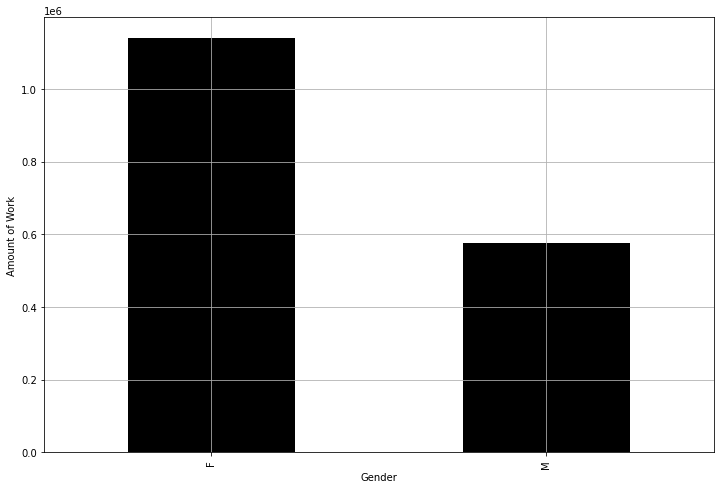

In [43]:
#Amount of work done by each gender
df.groupby("Gender")["Work"].count().plot(kind="bar", figsize=(12,8), xlabel="Gender", ylabel="Amount of Work", grid=True, color='black',orientation='vertical')

In [44]:
# Advance analysis
profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### PART D: Data Preprocessing

In [45]:
#Making new dataset with relevant features
dataset_new = df[["NumberofDays","Qty","ExtraKilos","Area","NumberOfTree"]]
dataset_new.head()

NumberofDays  Qty  ExtraKilos  Area  NumberOfTree
18414           1.0  0.0         0.0   1.5       19425.0
18415           1.0  0.0         0.0   0.8        9302.0
18416           1.0  0.0         0.0   0.8        9653.0
18417           1.0  0.0         0.0   5.0       31505.0
18418           1.0  0.0         0.0   5.8       30015.0

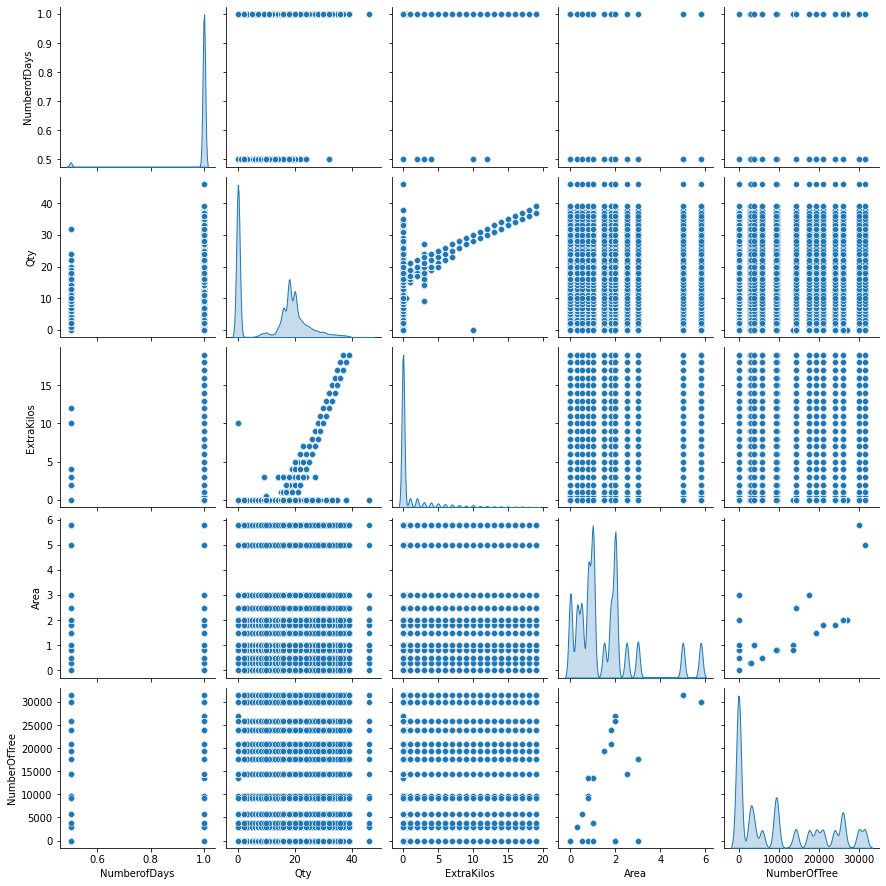

In [46]:
# Characteristic of the dataset
sns.pairplot(data=dataset_new, diag_kind='kde')

In [47]:
# Selecting values for train test split
X = dataset_new.iloc[:,[0,2,3,4]].values
# Target Variable "Qty"
Y = dataset_new.iloc[:, [1]].values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

In [48]:
# Scaling the values
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### PART E: Model Building

In [49]:
# Model 1
import lightgbm as lgbm
regressor = lgbm.LGBMRegressor()
regressor = regressor.fit(X_train,y_train)
Y_pred = regressor.predict(X_test)
Gradient_Boosting = regressor.score(X_test,y_test)
Y_pred = regressor.predict(X_test)
Gradient_Boosting_mean = mean_squared_error(y_test, Y_pred)
Gradient_Boosting_abs= mean_absolute_error(y_test, Y_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [50]:
# Model 2
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor = regressor.fit(X_train,y_train)
Y_pred = regressor.predict(X_test)
Linear_Regression = regressor.score(X_test,y_test)
Y_pred = regressor.predict(X_test)
Linear_regression_mean = mean_squared_error(y_test, Y_pred)
Linear_regression_abs = mean_absolute_error(y_test, Y_pred)

In [51]:
# Model 3
from sklearn.linear_model import ElasticNet
regressor = ElasticNet(selection="cyclic",l1_ratio=0.9, random_state=42,alpha=0.001)
regressor = regressor.fit(X_train,y_train)
Y_pred = regressor.predict(X_test)
Elastic = regressor.score(X_test,y_test)
Y_pred = regressor.predict(X_test)
ElasticNet_mean = mean_squared_error(y_test, Y_pred)
ElasticNet_abs = mean_absolute_error(y_test, Y_pred)

In [52]:
# Model 4
from sklearn.linear_model import BayesianRidge
regressor = BayesianRidge()
regressor = regressor.fit(X_train,y_train)
Y_pred = regressor.predict(X_test)
bayesian = regressor.score(X_test,y_test)
Y_pred = regressor.predict(X_test)
Bayesian_Ridge_mean = mean_squared_error(y_test, Y_pred)
Bayesian_Ridge_abs = mean_absolute_error(y_test, Y_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [53]:
# Results
columns = ["LGBM Regression", "Linear Regression", "ElasticNet Regression", "BayesianRidge Regression"]
scores = [Gradient_Boosting, Linear_Regression, Elastic, bayesian]
mean_squared_errors = [Gradient_Boosting_mean, Linear_regression_mean, ElasticNet_mean, Bayesian_Ridge_mean]
mean_absolute_errors = [Gradient_Boosting_abs, Linear_regression_abs, ElasticNet_abs, Bayesian_Ridge_abs]
result = pd.DataFrame({"Regression Techniques":columns, "Accuracy":scores,"MSE":mean_squared_errors,"MAE":mean_absolute_errors})
result


Regression Techniques  Accuracy        MSE       MAE
0           LGBM Regression  0.505476  55.529206  6.426690
1         Linear Regression  0.408489  66.419703  7.689930
2     ElasticNet Regression  0.408490  66.419566  7.689896
3  BayesianRidge Regression  0.408489  66.419702  7.689930

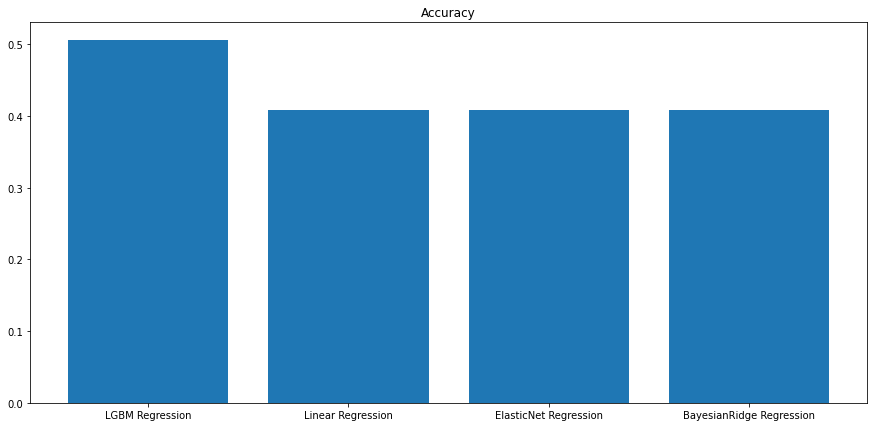

In [54]:
# Comparitive analysis
plt.rcParams["figure.figsize"] = (15,7)
plt.bar(result["Regression Techniques"], result["Accuracy"])
plt.title("Accuracy")
plt.show()


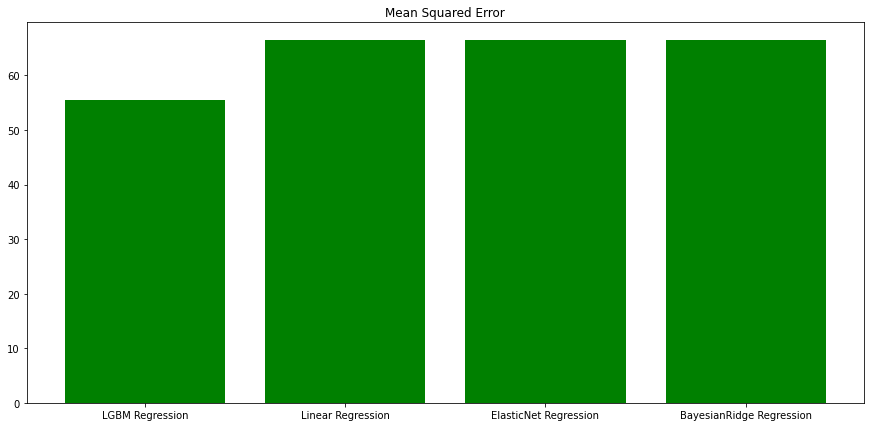

In [55]:
plt.rcParams["figure.figsize"] = (15,7)
plt.bar(result["Regression Techniques"], result["MSE"], color=("green"))
plt.title("Mean Squared Error")
plt.show()


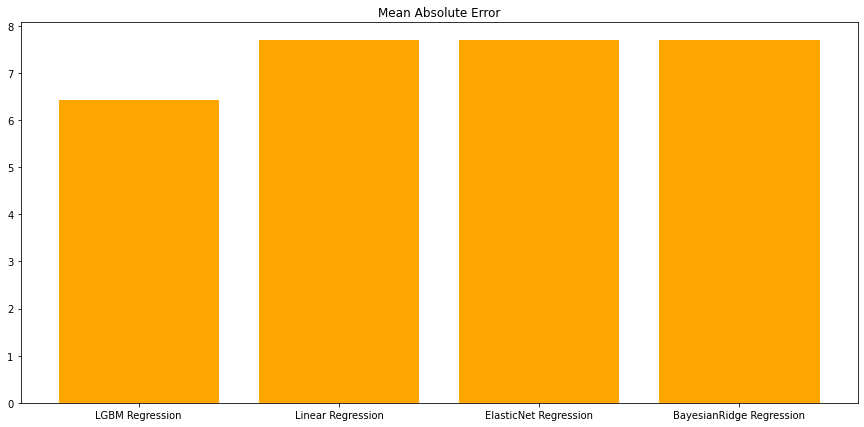

In [56]:
plt.rcParams["figure.figsize"] = (15,7)
plt.bar(result["Regression Techniques"], result["MAE"], color=("Orange"))
plt.title("Mean Absolute Error")
plt.show()